In [221]:
import pandas as pd 
import numpy as np
import json

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

import descriptors.preprocessing as pp
import descriptors.dft_featurisation as dft_ft
import descriptors.rdkit_featurisation as rdkit_ft
from analysis import analysis_train_set_size, random_split, stratified_split 

from rdkit import Chem
from rdkit.Chem import Draw

In [222]:
estimators = [('predictor', RandomForestRegressor())]
pipe = Pipeline(estimators)
metric = r2_score

In [223]:
df_dft = pd.read_csv("data/NiCOlit.csv", sep = ',')
df_dft = pp.preprocess(df_dft)
indexes_kept_dft = np.array(df_dft.index)
X_dft, y_dft, DOI_dft, mechanisms_dft, origins_dft, sub_dft, lig_dft = dft_ft.process_dataframe_dft(df_dft, data_path="data/utils/", origin=False)

##### Restricted models

Restricted models for substrate and coupling partner

Taking the R2_score of the whole model_values and values obtained on the n_iterations

In [224]:
n_iterations = 100

Substrate

In [225]:
r2_sub = []
length_sub = []
for sub in np.unique(sub_dft):
    indexes = np.where(sub_dft==sub)[0]
    values, baseline_values, model_values, stratification_values, additional_stratification_values = random_split(X_dft[indexes, :], y_dft[indexes], origins_dft[indexes], 
                                                                                                                  sub_dft[indexes], n_iterations=n_iterations)
    print(sub, len(indexes), round(r2_score(values, model_values), 3))
    r2_sub.append(round(r2_score(values, model_values), 3))
    length_sub.append(len(indexes))

OAc 72 0.404
OC(=O)N 215 0.348
OC(=O)O 82 0.641
OCH3 546 0.569
OCOC 17 -0.367
OPh 3 -1.304
OPiv 394 0.555
OSi(C)(C)C 23 -0.284
Otriazine 54 0.391


Coupling Partners

In [226]:
r2_cp = []
length_cp = []
for sub in np.unique(mechanisms_dft):
    indexes = np.where(mechanisms_dft==sub)[0]
    values, baseline_values, model_values, stratification_values, additional_stratification_values = random_split(X_dft[indexes, :], y_dft[indexes], origins_dft[indexes], 
                                                                                                                  mechanisms_dft[indexes], n_iterations=n_iterations)
    print(sub, len(indexes), round(r2_score(values, model_values), 3))
    r2_cp.append(round(r2_score(values, model_values),3))
    length_cp.append(len(indexes))

Al 53 0.175
B 472 0.447
C-H 271 0.557
CO2 87 0.497
Li 52 0.044
NCO 57 0.29
NH 27 -0.031
RMgX 266 0.476
Si 53 0.591
Zn 68 0.573


DOI

Both R2_score of the full model and mean of the R2_score obtained on each splits are printed

In [227]:
r2_doi = []
r2_mean_doi = []
print("DOI", "number of reactions", "r2_full", "mean_r2s", "std_r2s")
for sub in np.unique(DOI_dft):
    indexes = np.where(DOI_dft==sub)[0]
    values, baseline_values, model_values, stratification_values, additional_stratification_values = random_split(X_dft[indexes, :], y_dft[indexes], origins_dft[indexes],
                                                                                                                  DOI_dft[indexes], n_iterations=n_iterations)
    r2 = []
    n = int(len(values)/n_it)
    for i in range(n_it):
        r2.append(r2_score(values[i*n: (i+1)*n], model_values[i*n: (i+1)*n]))
    print(sub, len(indexes), round(r2_score(values, model_values), 3), round(np.mean(r2), 3), round(np.std(r2),3))
    r2_doi.append(round(r2_score(values, model_values),3))
    r2_mean_doi.append(round(np.mean(r2), 3))
    
    
    

DOI number of reactions r2_full mean_r2s std_r2s
Thèse 46 0.158 -0.291 1.995
https://doi.org/10.1002/adsc.201600590 53 0.59 0.476 0.336
https://doi.org/10.1002/anie.200453765 59 0.639 0.539 0.245
https://doi.org/10.1002/anie.200907287 27 -0.055 -0.69 1.638
https://doi.org/10.1002/anie.201403823 76 0.67 0.63 0.22
https://doi.org/10.1002/chem.201003731 55 0.464 0.401 0.396
https://doi.org/10.1002/chem.201103784 54 0.669 0.662 0.389
https://doi.org/10.1002/chem.201603436 66 0.092 0.03 0.369
https://doi.org/10.1002/ejic.201900692 84 0.468 0.396 0.307
https://doi.org/10.1021/acs.joc.6b01627 21 0.048 -4.284 12.967
https://doi.org/10.1021/acs.organomet.9b00543 53 0.179 0.106 0.405
https://doi.org/10.1021/acs.orglett.6b02656 36 0.127 -0.129 1.122
https://doi.org/10.1021/acscatal.7b01058 53 0.165 -0.356 2.08
https://doi.org/10.1021/acscatal.8b03436 152 0.624 0.603 0.146
https://doi.org/10.1021/ja410883p 87 0.498 0.463 0.239
https://doi.org/10.1021/ja412107b 50 0.225 -0.204 1.343
https://doi.org

In [228]:
dict_r2_local = dict()
for i, doi in enumerate(np.unique(DOI_dft)):
    dict_r2_local.update({doi: r2_doi[i]})

##### Full Model on Diverse DOI

In [229]:
# attention ça prends du temps
r2_scores_full_model_doi = []
values, baseline_values, model_values, stratification_values, additional_stratification_values = random_split(X_dft, y_dft, origins_dft, 
                                                                                                              DOI_dft, n_iterations=10*n_iterations)

In [230]:
# global model results
for doi in np.unique(DOI_dft):
    indexes = np.where(np.array(additional_stratification_values)==doi)[0]
    print(doi, len(indexes), round(r2_score(np.take(values, indexes), np.take(model_values, indexes)), 3))
    r2_scores_full_model_doi.append(round(r2_score(values, model_values),3))

Thèse 9006 0.183
https://doi.org/10.1002/adsc.201600590 10715 0.579
https://doi.org/10.1002/anie.200453765 11886 0.637
https://doi.org/10.1002/anie.200907287 5402 0.095
https://doi.org/10.1002/anie.201403823 15258 0.678
https://doi.org/10.1002/chem.201003731 11122 0.461
https://doi.org/10.1002/chem.201103784 10912 0.691
https://doi.org/10.1002/chem.201603436 13214 -0.002
https://doi.org/10.1002/ejic.201900692 16918 0.57
https://doi.org/10.1021/acs.joc.6b01627 4234 0.196
https://doi.org/10.1021/acs.organomet.9b00543 10704 0.174
https://doi.org/10.1021/acs.orglett.6b02656 7238 0.262
https://doi.org/10.1021/acscatal.7b01058 10494 0.231
https://doi.org/10.1021/acscatal.8b03436 30592 0.595
https://doi.org/10.1021/ja410883p 17419 0.501
https://doi.org/10.1021/ja412107b 10096 0.188
https://doi.org/10.1021/ja5029793 11359 0.444
https://doi.org/10.1021/ja8056503 15865 0.416
https://doi.org/10.1021/ja907700e 5401 0.059
https://doi.org/10.1021/jo1024464 4476 -0.364
https://doi.org/10.1021/jo40055

In [231]:
R2_scores_full_model = [0.184, 0.577, 0.637, 0.089, 0.678, 0.459,
                       0.692, -0.003, 0.569, 0.195, 0.177, 0.262,
                       0.231, 0.595, 0.502, 0.185, 0.443, 0.417, 0.061,
                       -0.352, 0.337, 0.276, 0.444, 0.272, 0.101, 0.737]

dict_r2_global = dict()
for i, doi in enumerate(np.unique(DOI_dft)):
    dict_r2_global.update({doi: r2_scores_full_model_doi[i]})

##### scope-opt baseline
Again the mean of the r2 scores on the differents splits and the r2 score of all the splits is displayed

In [232]:
from sklearn.model_selection import train_test_split

n_splits = 10000
r2_scores_scop_opt = []

print("DOI/Number of Reactions/r2_full_splits/mean_r2s +/- var_r2s")
for sub in np.unique(DOI_dft):
    indexes = np.where(DOI_dft==sub)[0]
    X_doi = X_dft[indexes, :]
    y_doi = y_dft[indexes]
    origins_doi = origins_dft[indexes]
    r2_doi = []
    Y_test = []
    Y_pred = []
    for i in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(origins_doi, y_doi, test_size=0.2, random_state=i)
        y_opt = np.mean(y_train[np.where(X_train == 'Optimisation')])
        y_sco = np.mean(y_train[np.where(X_train == 'Scope')])
        y_pred = [y_opt if i == 'Optimisation' else y_sco for i in X_test]
        r2_doi.append(r2_score(y_test, y_pred))
        Y_test.append(y_test)
        Y_pred.append(y_pred)
    m_r2_doi = np.mean(r2_doi)
    print(sub, len(indexes), round(r2_score(Y_test, Y_pred), 3), round(m_r2_doi, 3), '+/-', round(np.var(r2_doi), 3))
    r2_scores_scop_opt.append(round(r2_score(Y_test, Y_pred), 3))

DOI/Number of Reactions/r2_full_splits/mean_r2s +/- var_r2s
Thèse 46 0.071 -12.666 +/- 153404.065
https://doi.org/10.1002/adsc.201600590 53 0.413 0.224 +/- 0.605
https://doi.org/10.1002/anie.200453765 59 0.087 -0.136 +/- 0.512
https://doi.org/10.1002/anie.200907287 27 0.042 -1.26 +/- 16.394
https://doi.org/10.1002/anie.201403823 76 0.286 0.235 +/- 0.06
https://doi.org/10.1002/chem.201003731 55 0.162 -0.127 +/- 0.874
https://doi.org/10.1002/chem.201103784 54 0.102 -0.138 +/- 0.473
https://doi.org/10.1002/chem.201603436 66 -0.072 -0.207 +/- 0.146
https://doi.org/10.1002/ejic.201900692 84 0.04 -0.066 +/- 0.125
https://doi.org/10.1021/acs.joc.6b01627 21 0.276 -4.156 +/- 857.757
https://doi.org/10.1021/acs.organomet.9b00543 53 -0.052 -0.179 +/- 0.111
https://doi.org/10.1021/acs.orglett.6b02656 36 0.128 -0.395 +/- 20.191
https://doi.org/10.1021/acscatal.7b01058 53 0.183 -0.232 +/- 3.555
https://doi.org/10.1021/acscatal.8b03436 152 -0.01 -0.039 +/- 0.007
https://doi.org/10.1021/ja410883p 87 0

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-pack

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-pack

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-pack

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-pack

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-pack

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-pack

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-pack

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-pack

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-pack

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-pack

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-pack

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-pack

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-pack

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-pack

https://doi.org/10.1021/ja412107b 50 -0.046 -0.596 +/- 483.467
https://doi.org/10.1021/ja5029793 57 0.094 0.005 +/- 0.104
https://doi.org/10.1021/ja8056503 79 0.439 0.388 +/- 0.069
https://doi.org/10.1021/ja907700e 27 -0.089 -0.636 +/- 3.555
https://doi.org/10.1021/jo1024464 23 -0.059 -0.843 +/- 3.688
https://doi.org/10.1021/jo4005537 57 0.343 0.205 +/- 1.38
https://doi.org/10.1021/ol101592r 27 0.208 -0.199 +/- 6.938
https://doi.org/10.1039/B718998B 32 0.226 -1.509 +/- 582.348
https://doi.org/10.1039/C3CC46663A 62 0.062 -0.045 +/- 0.178
https://doi.org/10.1039/C5SC02942B 43 0.233 -0.217 +/- 1.71
https://doi.org/10.1246/cl.2011.913 27 0.809 0.065 +/- 357.384


In [233]:
dict_r2_scope_opt = dict()
for i, doi in enumerate(np.unique(DOI_dft)):
    dict_r2_scope_opt.update({doi: r2_scores_scop_opt[i]})

##### Benchmark coupling partner restricted models on DOI

In [234]:
df_dft = pd.read_csv("data/NiCOlit.csv", sep = ',')
df_dft = pp.preprocess(df_dft)
indexes_kept_dft = np.array(df_dft.index)
X_dft, y_dft, DOI_dft, cp_dft, origins_dft, sub_dft, lig_dft = dft_ft.process_dataframe_dft(df_dft, data_path="data/utils/", origin=False)

In [235]:
# check the number of mechanisms by DOI
doi_to_cp = dict()
for doi in np.unique(DOI_dft):
    indexes = np.where(DOI_dft==doi)
    print(doi, np.unique(cp_dft[indexes]))
    if len(np.unique(cp_dft[indexes])) == 1:
        doi_to_cp.update({doi: np.unique(cp_dft[indexes])[0]})

Thèse ['B']
https://doi.org/10.1002/adsc.201600590 ['Si']
https://doi.org/10.1002/anie.200453765 ['RMgX']
https://doi.org/10.1002/anie.200907287 ['NH']
https://doi.org/10.1002/anie.201403823 ['C-H']
https://doi.org/10.1002/chem.201003731 ['RMgX']
https://doi.org/10.1002/chem.201103784 ['Zn']
https://doi.org/10.1002/chem.201603436 ['Li' 'Zn']
https://doi.org/10.1002/ejic.201900692 ['RMgX']
https://doi.org/10.1021/acs.joc.6b01627 ['B']
https://doi.org/10.1021/acs.organomet.9b00543 ['B']
https://doi.org/10.1021/acs.orglett.6b02656 ['RMgX']
https://doi.org/10.1021/acscatal.7b01058 ['Al']
https://doi.org/10.1021/acscatal.8b03436 ['C-H']
https://doi.org/10.1021/ja410883p ['CO2']
https://doi.org/10.1021/ja412107b ['B']
https://doi.org/10.1021/ja5029793 ['NCO']
https://doi.org/10.1021/ja8056503 ['B']
https://doi.org/10.1021/ja907700e ['B']
https://doi.org/10.1021/jo1024464 ['B']
https://doi.org/10.1021/jo4005537 ['B']
https://doi.org/10.1021/ol101592r ['B']
https://doi.org/10.1039/B718998B ['R

Excepted for one doi, all publications only have one coupling partner inside

In [236]:
n_it = 100
R2_cp_restricted_doi = []
dict_r2_cp_doi = dict()

# restriction to the cp covering more than one publication
for cp in ['B', 'RMgX', 'C-H']:
    # train cp-partner model
    indexes = np.where(cp_dft==cp)[0]
    values, baseline_values, model_values, stratification_values, additional_stratification_values = random_split(X_dft[indexes, :], y_dft[indexes], origins_dft[indexes], 
                                                                                                                  DOI_dft[indexes], n_iterations=n_it)

    # retrieve dois having this cp
    list_dois = []
    for doi in doi_to_cp.keys():
        if doi_to_cp[doi] == cp:
            list_dois.append(doi)
            
    # evaluate performances on the doi:
    for doi in list_dois:
        indexes_doi = np.where(np.array(additional_stratification_values)==doi)[0]
        r2 = r2_score(np.take(values,indexes_doi), np.take(model_values,indexes_doi))
        R2_cp_restricted_doi.append(r2)
        print(doi, round(r2,3))
        dict_r2_cp_doi.update({doi: round(r2,3)})


Thèse 0.245
https://doi.org/10.1021/acs.joc.6b01627 0.205
https://doi.org/10.1021/acs.organomet.9b00543 0.089
https://doi.org/10.1021/ja412107b 0.183
https://doi.org/10.1021/ja8056503 0.425
https://doi.org/10.1021/ja907700e 0.085
https://doi.org/10.1021/jo1024464 -0.467
https://doi.org/10.1021/jo4005537 0.304
https://doi.org/10.1021/ol101592r 0.397
https://doi.org/10.1039/C3CC46663A 0.174
https://doi.org/10.1246/cl.2011.913 0.706
https://doi.org/10.1002/anie.200453765 0.612
https://doi.org/10.1002/chem.201003731 0.498
https://doi.org/10.1002/ejic.201900692 0.57
https://doi.org/10.1021/acs.orglett.6b02656 0.185
https://doi.org/10.1039/B718998B 0.477
https://doi.org/10.1002/anie.201403823 0.61
https://doi.org/10.1021/acscatal.8b03436 0.61
https://doi.org/10.1039/C5SC02942B 0.161


In [237]:
for doi in dict_r2_cp_doi:
    if type(dict_r2_cp_doi[doi]) == np.float64:
        dict_r2_cp_doi.update({doi: round(dict_r2_cp_doi[doi],2)})

##### Calculate Accessibles Spaces

In [238]:
# measure the accesible space for different splittings
def accessible_space(df, category_class):
    d = dict()
    for sub in np.unique(df_dft[category_class]):
        sub_df = df_dft[df_dft[category_class]==sub]
        n_sub = len(sub_df.substrate.unique())
        n_cp = len(sub_df.effective_coupling_partner.unique())
        n_lig = len(sub_df.effective_ligand.unique())
        n_reag = len(sub_df.effective_reagents.unique())
        n_sol = len(sub_df.solvent.unique())
        n_prec = len(sub_df.catalyst_precursor.unique())
        print(sub, ":", "{:e}".format(n_sub*n_cp*n_lig*n_reag*n_sol*n_prec))
        d.update({sub:n_sub*n_cp*n_lig*n_reag*n_sol*n_prec})
    return d

df_dft['substrate_class'] = sub_dft
print("coupling partner")
accessible_space(df_dft, 'coupling_partner_class')
print("\nsubstrate")
accessible_space(df_dft, 'substrate_class')
print("\nDOIs")
dict_access_doi = accessible_space(df_dft, 'DOI')

coupling partner
Al : 3.952000e+04
B : 4.481160e+09
C-H : 5.225220e+08
CO2 : 1.088640e+05
Li : 1.744200e+04
NCO : 3.316950e+05
NH : 9.000000e+02
RMgX : 1.102608e+07
Si : 9.792000e+04
Zn : 2.880000e+03

substrate
OAc : 4.193280e+06
OC(=O)N : 1.434921e+08
OC(=O)O : 4.490640e+05
OCH3 : 5.397859e+09
OCOC : 3.240000e+03
OPh : 4.860000e+02
OPiv : 3.198075e+09
OSi(C)(C)C : 9.600000e+03
Otriazine : 1.815000e+05

DOIs
Thèse : 1.280000e+03
https://doi.org/10.1002/adsc.201600590 : 9.792000e+04
https://doi.org/10.1002/anie.200453765 : 8.019000e+04
https://doi.org/10.1002/anie.200907287 : 9.000000e+02
https://doi.org/10.1002/anie.201403823 : 2.545920e+05
https://doi.org/10.1002/chem.201003731 : 4.725000e+03
https://doi.org/10.1002/chem.201103784 : 7.680000e+02
https://doi.org/10.1002/chem.201603436 : 2.970000e+04
https://doi.org/10.1002/ejic.201900692 : 1.684800e+04
https://doi.org/10.1021/acs.joc.6b01627 : 2.400000e+02
https://doi.org/10.1021/acs.organomet.9b00543 : 1.620000e+03
https://doi.org/10

In [239]:
# make SI table:
for doi in np.unique(DOI_dft):
    if doi not in dict_r2_cp_doi.keys():
        dict_r2_cp_doi.update({doi:'-'})
for doi in np.unique(DOI_dft):
    print(doi.replace('https://doi.org/',''), 
          '&', round(dict_r2_global[doi],2),
          '&', dict_r2_cp_doi[doi],
          '&', round(dict_r2_local[doi],2),
       #   '&', dict_r2_scope_opt[doi], 
          '&', len(np.where(DOI_dft==doi)[0]),
       #   '&', dict_access_doi[doi], 
          '\\\ [0.5ex]'
         )

Thèse & 0.54 & 0.24 & 0.16 & 46 \\ [0.5ex]
10.1002/adsc.201600590 & 0.54 & - & 0.59 & 53 \\ [0.5ex]
10.1002/anie.200453765 & 0.54 & 0.61 & 0.64 & 59 \\ [0.5ex]
10.1002/anie.200907287 & 0.54 & - & -0.06 & 27 \\ [0.5ex]
10.1002/anie.201403823 & 0.54 & 0.61 & 0.67 & 76 \\ [0.5ex]
10.1002/chem.201003731 & 0.54 & 0.5 & 0.46 & 55 \\ [0.5ex]
10.1002/chem.201103784 & 0.54 & - & 0.67 & 54 \\ [0.5ex]
10.1002/chem.201603436 & 0.54 & - & 0.09 & 66 \\ [0.5ex]
10.1002/ejic.201900692 & 0.54 & 0.57 & 0.47 & 84 \\ [0.5ex]
10.1021/acs.joc.6b01627 & 0.54 & 0.2 & 0.05 & 21 \\ [0.5ex]
10.1021/acs.organomet.9b00543 & 0.54 & 0.09 & 0.18 & 53 \\ [0.5ex]
10.1021/acs.orglett.6b02656 & 0.54 & 0.18 & 0.13 & 36 \\ [0.5ex]
10.1021/acscatal.7b01058 & 0.54 & - & 0.16 & 53 \\ [0.5ex]
10.1021/acscatal.8b03436 & 0.54 & 0.61 & 0.62 & 152 \\ [0.5ex]
10.1021/ja410883p & 0.54 & - & 0.5 & 87 \\ [0.5ex]
10.1021/ja412107b & 0.54 & 0.18 & 0.22 & 50 \\ [0.5ex]
10.1021/ja5029793 & 0.54 & - & 0.3 & 57 \\ [0.5ex]
10.1021/ja8056503 

##### visualize molecules per category

In [6]:
for sub in np.unique(sub_dft):
    indexes = np.where(sub_dft==sub)[0]
    smis = np.unique(df_dft.substrate[indexes])
    img  = Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in smis[:6]], 
                            maxMols=500, useSVG=True,
                                molsPerRow=3)
    filename = str('sub_' + str(sub) + '.svg')
    with open(filename, 'w') as f:
        f.write(img.data)

In [106]:
sub = 'OC(=O)N'
indexes = np.where(sub_dft==sub)[0]
smis = np.unique(df_dft.substrate[indexes])

57


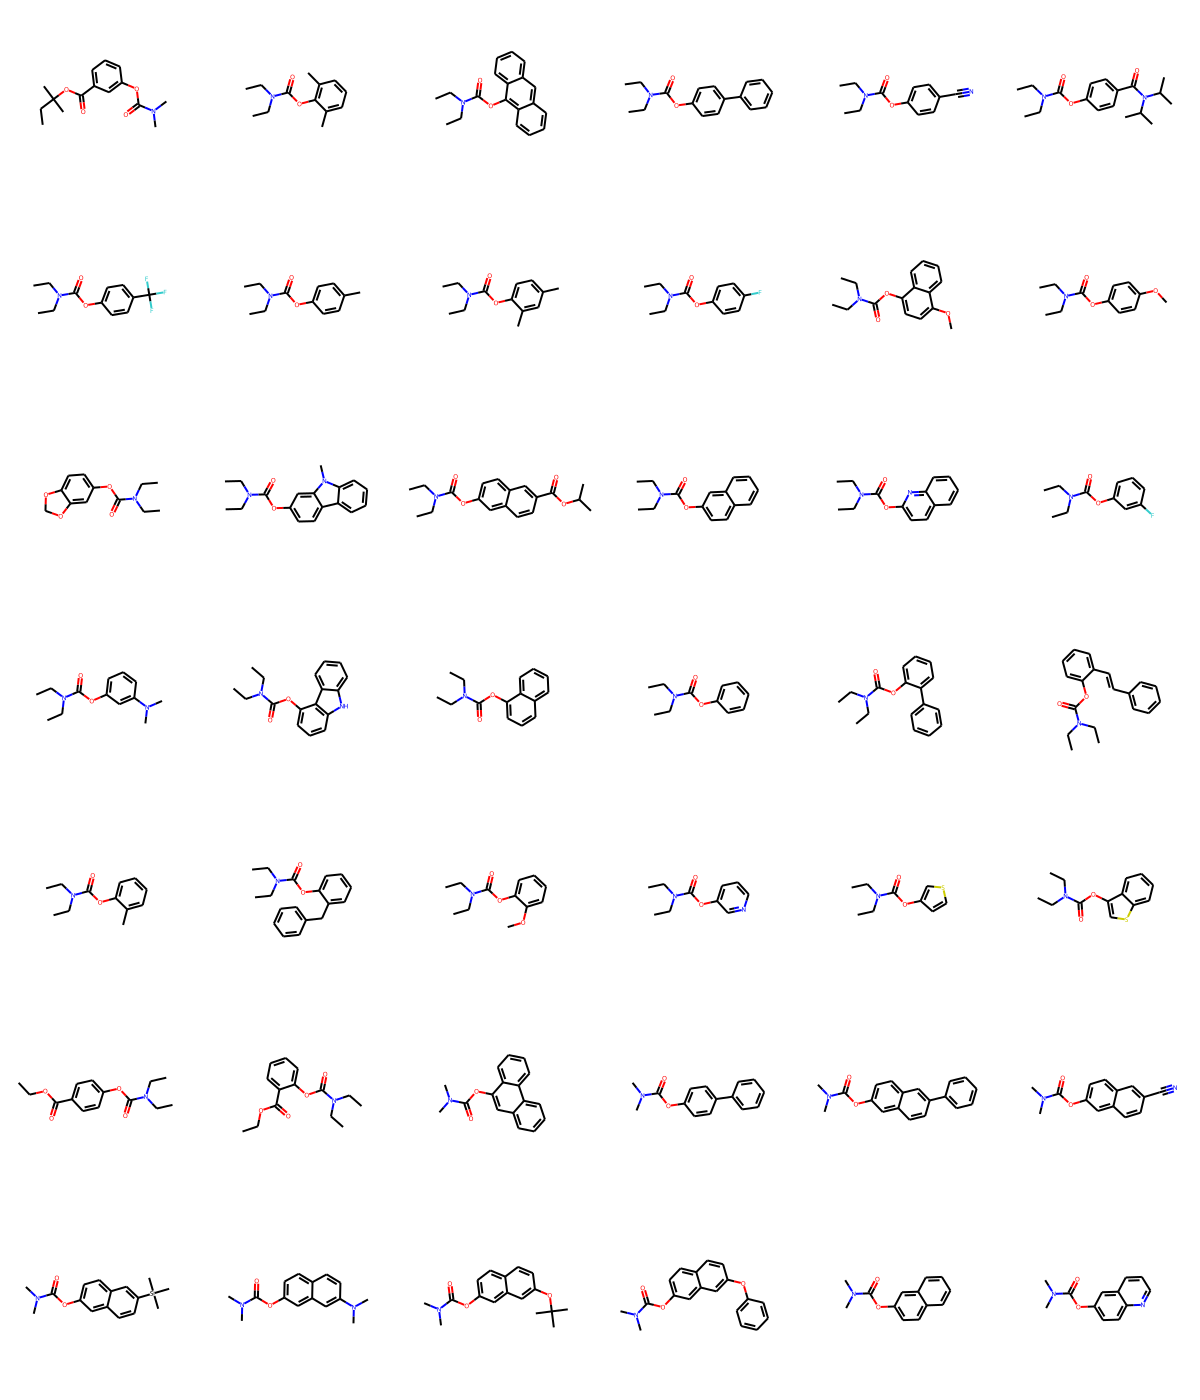

In [109]:
smis_under48 = smis[:42]
img  = Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in smis_under48], 
                            maxMols=500, useSVG=True,
                                molsPerRow=6)
filename = str('sub_' + str(sub) + '1.svg')
with open(filename, 'w') as f:
    f.write(img.data)  

In [7]:
for cp in np.unique(mechanisms_dft):
    indexes = np.where(mechanisms_dft==cp)[0]
    smis = np.unique(df_dft.coupling_partner[indexes])
    img  = Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in smis[:6]], 
                            maxMols=500, useSVG=True,
                                molsPerRow=3)
    filename = str('cp_' + str(cp) + '.svg')
    with open(filename, 'w') as f:
        f.write(img.data)

In [113]:
cp = 'C-H'
indexes = np.where(mechanisms_dft==cp)[0]
smis = np.unique(df_dft.coupling_partner[indexes])

51


In [116]:
smis_under48 = smis[:42]
img  = Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in smis_under48], 
                            maxMols=500, useSVG=True,
                                molsPerRow=6)
filename = str('cp_' + str(cp) + '1.svg')
with open(filename, 'w') as f:
    f.write(img.data)

In [76]:
from rdkit.Chem import Draw
from rdkit import Chem
img  = Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in smis], 
                            maxMols=500, useSVG=True,
                            molsPerRow=6)

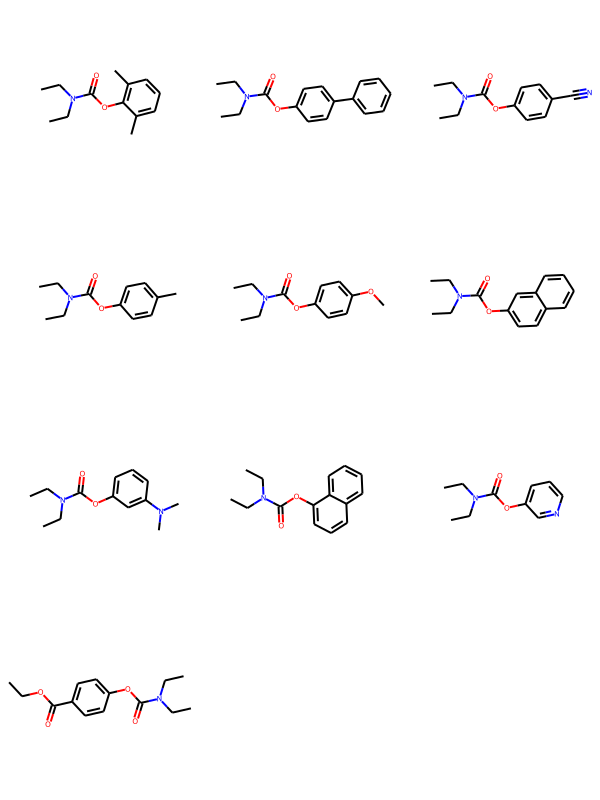

In [15]:
doi = 'https://doi.org/10.1021/jo1024464'
dois_indexes = np.where(df_dft.DOI == doi)[0]
smis = np.unique(df_dft.substrate[dois_indexes])
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in smis])